In [30]:
import os
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, callbacks, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [17]:
seed_value = 42

os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [18]:
with open('data_schema.json', 'r') as f:
    config = json.load(f)
    
spectro_cols = config['spectro_cols']
photo_cols = config['photometry_cols']
generic_cols = config['generic_cols']
target_col = config['target_col']

In [19]:
df = pd.read_csv(f"data/processed/photometry_only.csv")

X = df[photo_cols + generic_cols]
y = df[target_col]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_value)

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
input_shape = X_train_scaled.shape[1]

photo_input = keras.Input(shape=(input_shape,), name='photo_input')
x = layers.Dense(64, activation='relu', name='layer0_Dense64')(photo_input)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu', name='layer1_Dense128')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu', name='layer2_Dense256')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(512, activation='relu', name='layer3_Dense512')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu', name='layer4_Dense256')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu', name='layer5_Dense128')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu', name='layer6_Dense64')(x)
x = layers.Dropout(0.2)(x)

output = layers.Dense(1, name='logM_star')(x)

model = keras.Model(inputs=photo_input, outputs=output, name='PhotoOnly_Model_v1.0')

# Loading the weights into corresponding layers
model.load_weights(f'models/spec_photo_model_v1.0.h5', by_name=True, skip_mismatch=True)

model.get_layer('layer1_Dense128').trainable = True
model.get_layer('layer2_Dense256').trainable = False
model.get_layer('layer3_Dense512').trainable = True
model.get_layer('layer4_Dense256').trainable = False
model.get_layer('layer5_Dense128').trainable = True

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse', 'mape'])

model.summary()

Model: "PhotoOnly_Model_v1.0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 photo_input (InputLayer)    [(None, 39)]              0         
                                                                 
 layer0_Dense64 (Dense)      (None, 64)                2560      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 layer1_Dense128 (Dense)     (None, 128)               8320      
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 layer2_Dense256 (Dense)     (None, 256)               33024     
                                                                 
 dropout_9 (Dropout)         (None, 256)      

In [23]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])

Epoch 1/100
6093/6093 [==============================] - 42s 7ms/step - loss: 9355163.0000 - mae: 1047.8243 - mse: 9355163.0000 - mape: 1002.7521 - val_loss: 9056024.0000 - val_mae: 1249.0111 - val_mse: 9056024.0000 - val_mape: 3075.3289
Epoch 2/100
6093/6093 [==============================] - 56s 9ms/step - loss: 8770772.0000 - mae: 1474.4408 - mse: 8770772.0000 - mape: 5533.1074 - val_loss: 8706256.0000 - val_mae: 1639.5348 - val_mse: 8706256.0000 - val_mape: 7225.9497
Epoch 3/100
6093/6093 [==============================] - 47s 8ms/step - loss: 8658695.0000 - mae: 1683.9883 - mse: 8658695.0000 - mape: 7760.2773 - val_loss: 8692231.0000 - val_mae: 1720.0729 - val_mse: 8692231.0000 - val_mape: 8081.8984
Epoch 4/100
6093/6093 [==============================] - 37s 6ms/step - loss: 8657566.0000 - mae: 1714.3608 - mse: 8657566.0000 - mape: 8082.1636 - val_loss: 8692241.0000 - val_mae: 1719.8489 - val_mse: 8692241.0000 - val_mape: 8079.5205
Epoch 5/100
6093/6093 [=========================

In [24]:
# Save weights from the trained model
model.save_weights('models/photo_only_model_v1.0.h5')

In [25]:
y_pred_full = model.predict(X_test_scaled)

# Evaluate accuracy metrics
mae = mean_absolute_error(y_test, y_pred_full)
r2 = r2_score(y_test, y_pred_full)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_full))

print(f"Photometry-Only Model Evaluation:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

1904/1904 [==============================] - 3s 2ms/step
Photometry-Only Model Evaluation:
Mean Absolute Error (MAE): 1735.8262
Root Mean Squared Error (RMSE): 2960.5407
R² Score: -0.0000


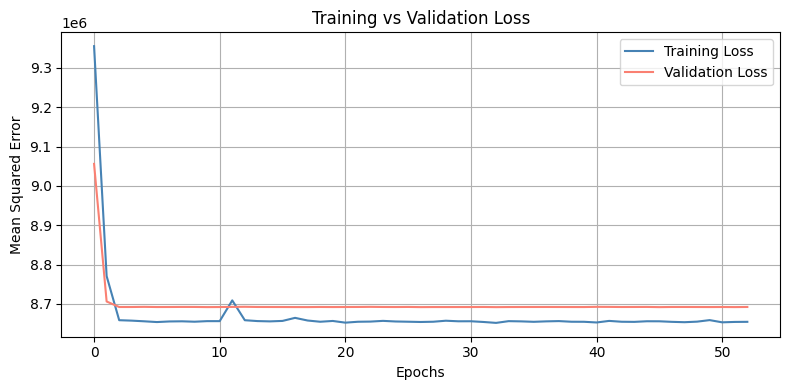

In [26]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss', color='steelblue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='salmon')
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

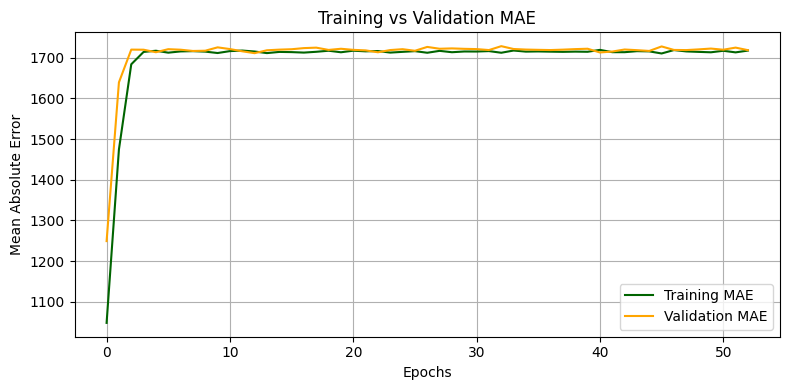

In [27]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['mae'], label='Training MAE', color='darkgreen')
plt.plot(history.history['val_mae'], label='Validation MAE', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.title("Training vs Validation MAE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
y_pred_full.flatten().shape, y_test.shape

((60924,), (60924, 1))

Text(0.5, 0, 'True Values')

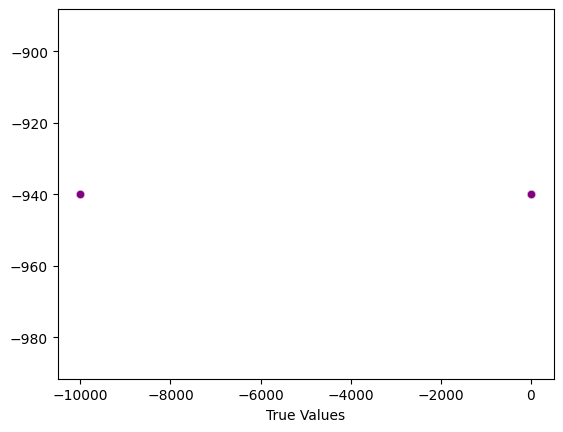

In [29]:
sns.scatterplot(x=y_test['logM_star'], y=y_pred_full.flatten(), color='purple', alpha=0.6)
plt.xlabel("True Values")